<a href="https://www.kaggle.com/code/aondofaalfred/titanic-machine-laerning-project?scriptVersionId=200850143" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

***titanic machine learning prediction
this notebook is about predicting the chances of survival of passangers on the titanic when the ship wrecked.
**overview
*understanding the data
*data cleaning
*examining relationships between features in the data
*feature engineering
*preparing data for model building
*building baseline models
*optimsing models by parameter tunning


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
train = pd.read_csv('/kaggle/input/c/titanic/train.csv')
test = pd.read_csv('/kaggle/input/c/titanic/test.csv')


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
#check properties of numeric columns
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
#cheking for columns with missing values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
# we fill the null values
#numeric columns are filled with mean values while categorical columns are filled with modal values

def fill_nulls(df):
    cols = df.columns
    for col in cols:
        if col in df.select_dtypes(include = ['float', 'int']).columns:
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
            
    return df
            
    
        

In [9]:
train = fill_nulls(train)
test = fill_nulls(test)

In [10]:

obj_cols = train.select_dtypes(include = 'object').columns.to_list()
num_cols = train.select_dtypes(include = ['int', 'float']).columns.to_list()
num_cols.remove('PassengerId')
num_cols



['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

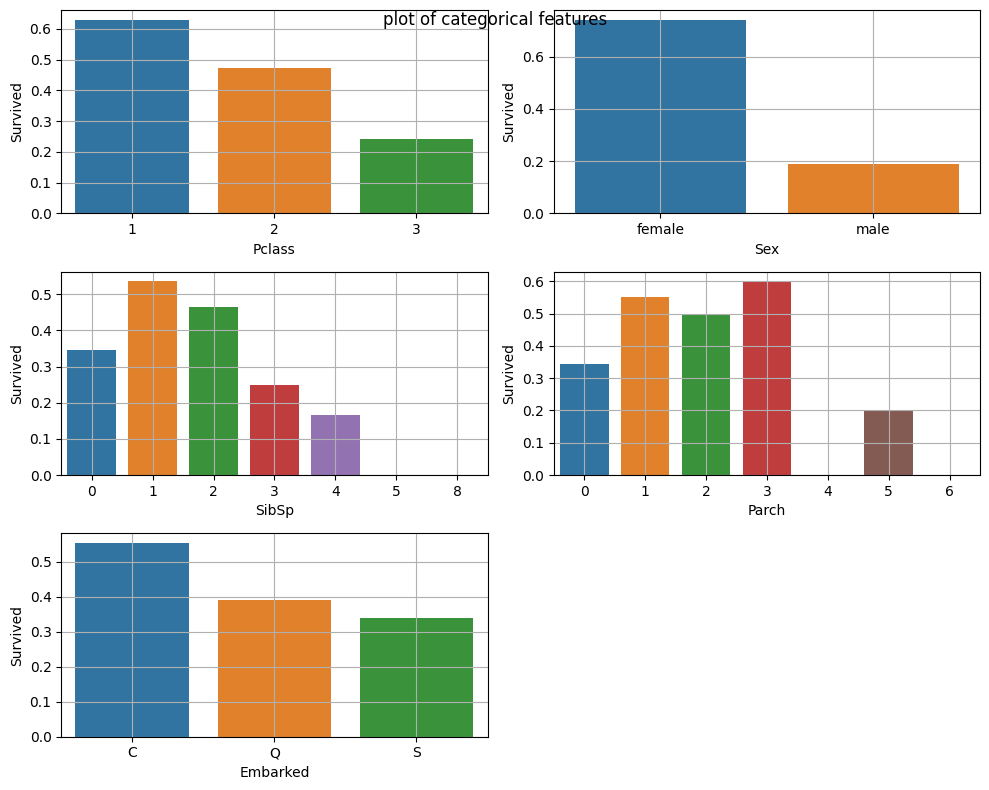

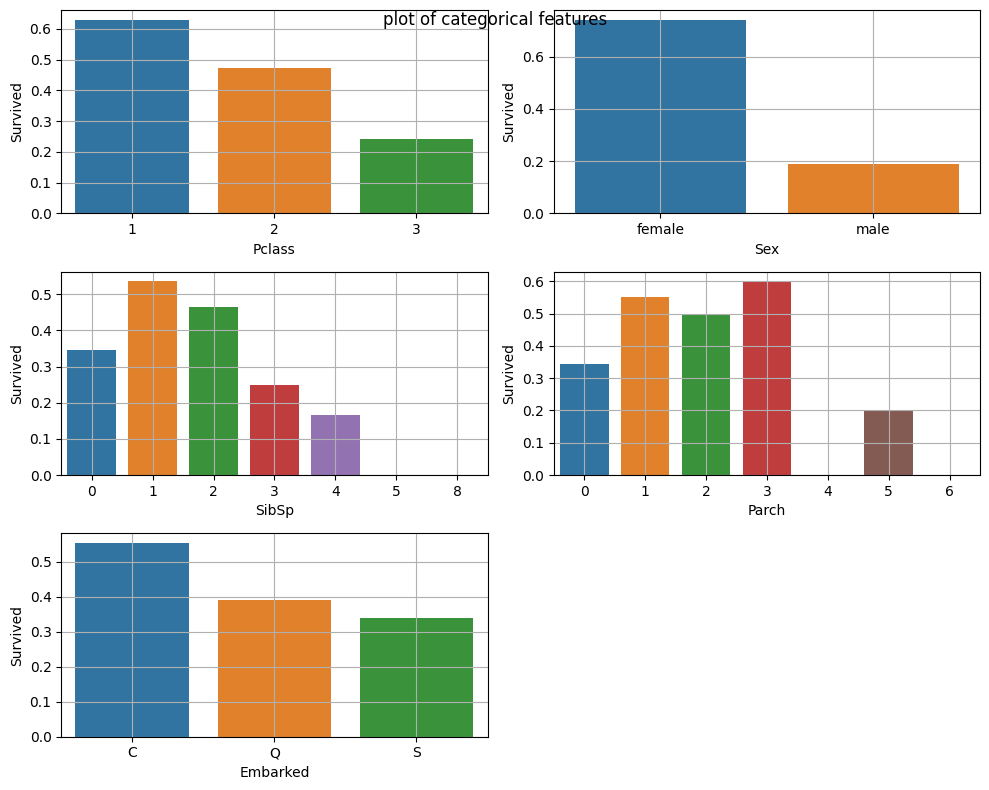

In [11]:
#visulising categorrical features
def plot_cat_cols(df):
    #we want to limit categorical columns to those with ten  distinct values or less 
    cols = [col for col in df.columns if  col != 'Survived' and df[col].nunique() in range(10)]
    fig = plt.figure(figsize = (10, 8))
    for i,  col in enumerate(cols):
        col_grp = train.groupby(col, as_index = False)['Survived'].mean().sort_values(by = 'Survived', ascending = False)
        ax = fig.add_subplot(3,2,i+1)
        sns.barplot(col_grp, x = col, y = 'Survived', ax =ax)
        ax.grid()
    plt.tight_layout()
    fig.suptitle('plot of categorical features')
    plt.show()
    return fig
        
    
    
plot_cat_cols(train) 

from the visual graphs:
pclass: passengers from higher socio-economic class stood a higher chance of survival
sex: females stood a better chance at survival than males
SibSp:passengers with fewer famimily relations stood a better chance at survival
embarked: survival rate for passangers varies according to the port of embarkation




feature engineering
we partitioned age into different bands to check for survival rate across the bands
Name:we extracted titles from names to check for trends in survival rates across different titles
Fare:does higher fare affects one's chances of survival?
family size: we combined parch and sibsp to form this feature and examine its effects on survival


In [12]:
def feat_eng(df):
    df['Age'] = pd.cut(df['Age'], bins = [12, 19, 35, 50, 65, 80], labels = ['child', 'teenage', 'adult', 'm_age', 'aged'])
    
    df['Name'] = df['Name'].str.extract('([A-Za-z]+)\.')
    df['Name'] = df['Name'].where(df['Name'].isin(['Mlle', 'Miss', 'Ms', 'Mme', 'Mrs', 'Mr']), 'other')
    df['Name'] = df['Name'].replace('Mlle', 'Mrs')
    df['Name'] = df['Name'].replace(['Mme', 'Ms'], 'Miss')
    df['Fare'] = pd.cut(df['Fare'], bins = 6, labels = list('abcdef'))
    df['Family_size'] = df['Parch'] + df['SibSp']
    
    
    
    return df

In [13]:

train = feat_eng(train)
test = feat_eng(test)


/tmp/ipykernel_33/2959053510.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby(col)['Survived'].mean().sort_values(ascending = False).plot(kind = 'bar')
/tmp/ipykernel_33/2959053510.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby(col)['Survived'].mean().sort_values(ascending = False).plot(kind = 'bar')


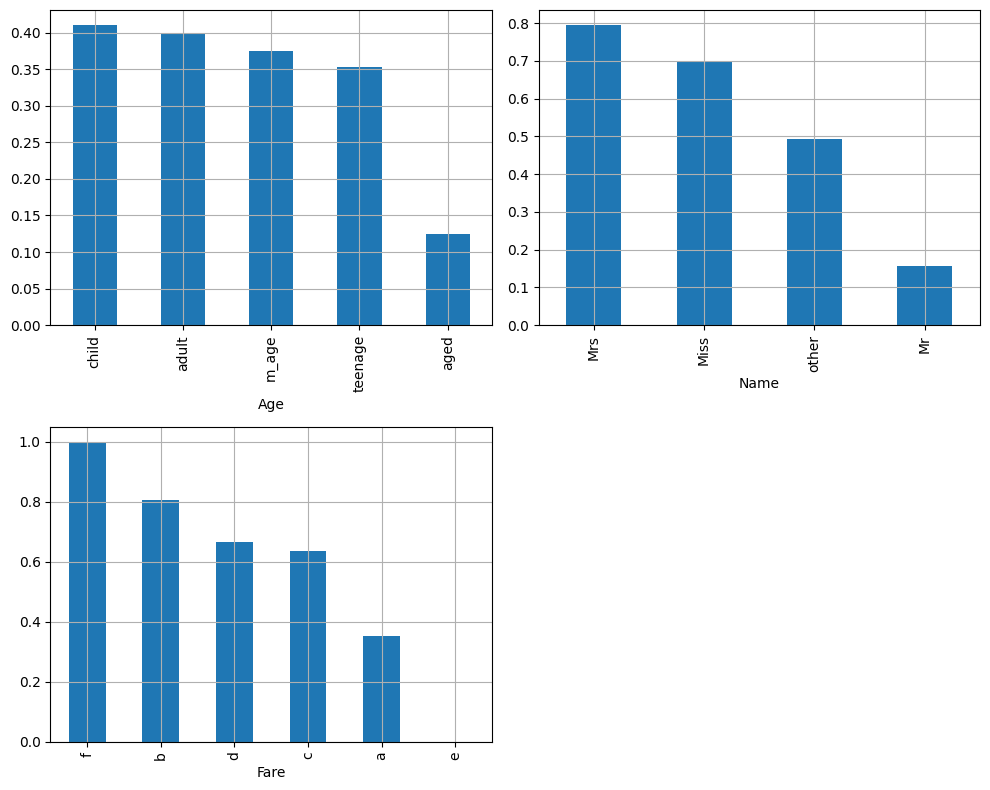

In [14]:
fig = plt.figure(figsize = (10, 8))
#ax1 = fig.add_subplot(221)
#ax2 = fig.add_subplot(222)
#ax3 = fig.add_subplot(223)
for i, col in enumerate(['Age', 'Name', 'Fare'], start = 1):
    ax = fig.add_subplot(2, 2, i)
    
    train.groupby(col)['Survived'].mean().sort_values(ascending = False).plot(kind = 'bar')
    ax.grid()
    
#train.groupby('Name')['Survived'].mean().sort_values(ascending = False).plot.bar(ax = ax2)
#train.groupby('Fare')['Survived'].mean().sort_values(ascending = False).plot.bar(ax = ax3)
plt.tight_layout()
plt.show()


In [15]:
# we will drop cabin, ticket and passengerid because  they seem not to have any effect on the target
train = train.drop(['Cabin', 'Ticket', 'PassengerId'], axis= 1)
x_test = test.drop(['Cabin', 'Ticket', 'PassengerId'], axis= 1)

In [18]:
x_train = train.drop('Survived', axis = 1)
y_train = train['Survived']


dtype('int64')

In [17]:
#we will do one-hot enocding on the categircal columns for out machine learning algorthm

cat_cols = [col for col if (col.dtype == 'object' abd train[col].nunique() <= 10)]
x_train = pd.get_dummies(x_train, columns = cat_cols, dtype = int)
x_test = pd.get_dummies(x_test, columns = cat_cols, dtype= int)

In [18]:
from sklearn.preprocessing import StandardScaler as sc

In [19]:
scale = sc()
x_train[['Parch', 'SibSp', 'Pclass']] = scale.fit_transform(x_train[['Parch', 'SibSp', 'Pclass']])

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [21]:
nb = GaussianNB()
cv = cross_val_score(nb, x_train, y_train, cv = 5)
print(cv)
print(cv.mean())


[0.68715084 0.7752809  0.75842697 0.7752809  0.79213483]
0.7576548866988888


In [22]:
lr = LogisticRegression(max_iter = 200)

cv = cross_val_score(lr, x_train, y_train, cv = 5)
print(cv)
print(cv.mean())


[0.82122905 0.80337079 0.80898876 0.81460674 0.8258427 ]
0.8148076078086749


In [23]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf, x_train, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.76536313 0.79775281 0.83146067 0.75280899 0.83146067]
0.7957692549118072


In [24]:
dt = DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt, x_train, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.75977654 0.81460674 0.80898876 0.75842697 0.83146067]
0.7946519364760529


In [25]:
sv = SVC(probability = True)
cv = cross_val_score(sv, x_train, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.8547486  0.82022472 0.82022472 0.80337079 0.84831461]
0.8293766869625259


In [26]:
xgb = XGBClassifier(random_state = 1)
cv = cross_val_score(xgb, x_train, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.75977654 0.80337079 0.79775281 0.75842697 0.84269663]
0.7924047454648171


In [27]:
from sklearn.ensemble import VotingClassifier

In [28]:
vc = VotingClassifier(estimators = [('lr', lr), ('nb', nb), ('rf', rf), ('sv', sv), ('xgb', xgb), ('dt', dt)], voting = 'soft')
cv = cross_val_score(vc, x_train, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.80446927 0.8258427  0.83707865 0.7752809  0.86516854]
0.821568012051974


In [29]:
vc.fit(x_train, y_train)
pred = vc.predict(x_test)
pred  = pd.DataFrame({'PassengerId':test.PassengerId, 'Survived':pred})
pred

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


model hyperparameter tunning

In [30]:
from sklearn.model_selection import GridSearchCV

In [31]:
def clf_performance(estimator):
    print(estimator)
    print('Best Score: ' + str(estimator.best_score_))
    print('Best Parameters: ' + str(estimator.best_params_))

In [32]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_lr = clf_lr.fit(x_train,y_train)
clf_performance(best_lr)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [2000], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             verbose=True)
Best Score: 0.8192894356914193
Best Parameters: {'C': 4.281332398719396, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}


In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(x_train,y_train)
clf_performance(best_clf_knn)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'n_neighbors': [3, 5, 7, 9], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=True)
Best Score: 0.8136965664427844
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [35]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(x_train,y_train)
clf_performance(best_clf_svc)

Fitting 5 folds for each of 55 candidates, totalling 275 fits
GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'gamma': [0.1, 0.5, 1, 2, 5, 10], 'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100, 1000], 'degree': [2, 3, 4, 5],
                          'kernel': ['poly']}],
             verbose=True)
Best Score: 0.8293766869625259
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [36]:
dt = DecisionTreeClassifier(random_state = 1)
param_grid = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

dt_cv = GridSearchCV(dt, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_dt = dt_cv.fit(x_train, y_train)
clf_performance(best_clf_dt)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             verbose=True)
Best Score: 0.8215742891218379
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10}


In [37]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(x_train,y_train)
clf_performance(best_clf_rf)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [15, 20, 25], 'min_samples_leaf': [2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [400, 450, 500, 550]},
             verbose=True)
Best Score: 0.8237963718536188
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 450}


<Axes: >

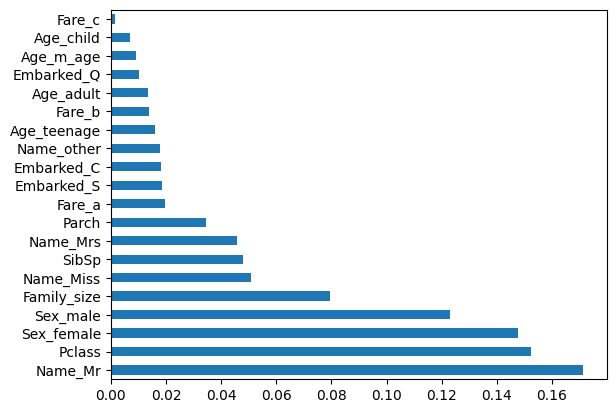

In [38]:
best_rf = best_clf_rf.best_estimator_.fit(x_train,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=x_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [39]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(x_train,y_train)
clf_performance(best_clf_xgb)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=1, ...),
          

In [40]:
y_hat_xgb = best_clf_xgb.best_estimator_.predict(x_test).astype(int)
xgb_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_xgb}
submission_xgb = pd.DataFrame(data=xgb_submission)
submission_xgb.to_csv('xgb_submission3.csv', index=False)